https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [6]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [7]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [16]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [2, 2, 2])

In [17]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [18]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [19]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified

In [20]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss / len(loader.dataset), epoch_acc / len(loader.dataset)

In [23]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None

EPOCHS = 40

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

EPOCHS : 0


Loss=0.298887699842453 Batch_id=87 Accuracy=89.97: 100%|██████████| 88/88 [00:36<00:00,  2.44it/s]



Validation set: Average loss: 0.0009, Accuracy: 4273/5000 (85.46%)


Test set: Average loss: 0.4764, Accuracy: 8512/10000 (85.12%)

EPOCHS : 1


Loss=0.2981129288673401 Batch_id=87 Accuracy=89.81: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0009, Accuracy: 4264/5000 (85.28%)


Test set: Average loss: 0.4626, Accuracy: 8532/10000 (85.32%)

EPOCHS : 2


Loss=0.25335824489593506 Batch_id=87 Accuracy=90.38: 100%|██████████| 88/88 [00:35<00:00,  2.48it/s]



Validation set: Average loss: 0.0009, Accuracy: 4290/5000 (85.80%)


Test set: Average loss: 0.4429, Accuracy: 8614/10000 (86.14%)

EPOCHS : 3


Loss=0.28099241852760315 Batch_id=87 Accuracy=90.74: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0008, Accuracy: 4313/5000 (86.26%)


Test set: Average loss: 0.4331, Accuracy: 8625/10000 (86.25%)

EPOCHS : 4


Loss=0.32031285762786865 Batch_id=87 Accuracy=91.21: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0008, Accuracy: 4345/5000 (86.90%)


Test set: Average loss: 0.4347, Accuracy: 8673/10000 (86.73%)

EPOCHS : 5


Loss=0.17366833984851837 Batch_id=87 Accuracy=91.39: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0008, Accuracy: 4326/5000 (86.52%)


Test set: Average loss: 0.4167, Accuracy: 8728/10000 (87.28%)

EPOCHS : 6


Loss=0.282592236995697 Batch_id=87 Accuracy=91.91: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0008, Accuracy: 4351/5000 (87.02%)


Test set: Average loss: 0.4146, Accuracy: 8662/10000 (86.62%)

EPOCHS : 7


Loss=0.2301790565252304 Batch_id=87 Accuracy=91.92: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0008, Accuracy: 4365/5000 (87.30%)


Test set: Average loss: 0.4210, Accuracy: 8688/10000 (86.88%)

EPOCHS : 8


Loss=0.19738075137138367 Batch_id=87 Accuracy=92.35: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0008, Accuracy: 4399/5000 (87.98%)

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.

Test set: Average loss: 0.3883, Accuracy: 8778/10000 (87.78%)

EPOCHS : 9


Loss=0.16154111921787262 Batch_id=87 Accuracy=94.22: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4493/5000 (89.86%)


Test set: Average loss: 0.3085, Accuracy: 9019/10000 (90.19%)

EPOCHS : 10


Loss=0.1467628926038742 Batch_id=87 Accuracy=95.05: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4513/5000 (90.26%)


Test set: Average loss: 0.3017, Accuracy: 9036/10000 (90.36%)

EPOCHS : 11


Loss=0.13408519327640533 Batch_id=87 Accuracy=95.40: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4518/5000 (90.36%)


Test set: Average loss: 0.3003, Accuracy: 9032/10000 (90.32%)

EPOCHS : 12


Loss=0.11111806333065033 Batch_id=87 Accuracy=95.47: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4520/5000 (90.40%)


Test set: Average loss: 0.3006, Accuracy: 9047/10000 (90.47%)

EPOCHS : 13


Loss=0.14924854040145874 Batch_id=87 Accuracy=95.63: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4530/5000 (90.60%)


Test set: Average loss: 0.2964, Accuracy: 9054/10000 (90.54%)

EPOCHS : 14


Loss=0.09969531744718552 Batch_id=87 Accuracy=95.56: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4535/5000 (90.70%)


Test set: Average loss: 0.2988, Accuracy: 9035/10000 (90.35%)

EPOCHS : 15


Loss=0.15422001481056213 Batch_id=87 Accuracy=95.78: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4516/5000 (90.32%)


Test set: Average loss: 0.2976, Accuracy: 9041/10000 (90.41%)

EPOCHS : 16


Loss=0.12776793539524078 Batch_id=87 Accuracy=95.95: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4523/5000 (90.46%)


Test set: Average loss: 0.2962, Accuracy: 9052/10000 (90.52%)

EPOCHS : 17


Loss=0.12350722402334213 Batch_id=87 Accuracy=96.08: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4520/5000 (90.40%)

Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.

Test set: Average loss: 0.2952, Accuracy: 9054/10000 (90.54%)

EPOCHS : 18


Loss=0.14224375784397125 Batch_id=87 Accuracy=96.05: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4528/5000 (90.56%)


Test set: Average loss: 0.2934, Accuracy: 9056/10000 (90.56%)

EPOCHS : 19


Loss=0.1593792885541916 Batch_id=87 Accuracy=96.00: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.2929, Accuracy: 9056/10000 (90.56%)

EPOCHS : 20


Loss=0.12193109840154648 Batch_id=87 Accuracy=96.02: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4528/5000 (90.56%)

Epoch 00021: reducing learning rate of group 0 to 1.2500e-06.

Test set: Average loss: 0.2930, Accuracy: 9061/10000 (90.61%)

EPOCHS : 21


Loss=0.1469707489013672 Batch_id=87 Accuracy=96.12: 100%|██████████| 88/88 [00:35<00:00,  2.48it/s]



Validation set: Average loss: 0.0006, Accuracy: 4523/5000 (90.46%)


Test set: Average loss: 0.2945, Accuracy: 9054/10000 (90.54%)

EPOCHS : 22


Loss=0.10766169428825378 Batch_id=87 Accuracy=96.01: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4528/5000 (90.56%)


Test set: Average loss: 0.2928, Accuracy: 9051/10000 (90.51%)

EPOCHS : 23


Loss=0.11962193995714188 Batch_id=87 Accuracy=96.02: 100%|██████████| 88/88 [00:35<00:00,  2.48it/s]



Validation set: Average loss: 0.0006, Accuracy: 4527/5000 (90.54%)

Epoch 00024: reducing learning rate of group 0 to 6.2500e-08.

Test set: Average loss: 0.2933, Accuracy: 9060/10000 (90.60%)

EPOCHS : 24


Loss=0.11549177020788193 Batch_id=87 Accuracy=96.08: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.2930, Accuracy: 9055/10000 (90.55%)

EPOCHS : 25


Loss=0.15349888801574707 Batch_id=87 Accuracy=96.00: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.2931, Accuracy: 9056/10000 (90.56%)

EPOCHS : 26


Loss=0.14157523214817047 Batch_id=87 Accuracy=96.28: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4530/5000 (90.60%)

Epoch 00027: reducing learning rate of group 0 to 3.1250e-09.

Test set: Average loss: 0.2929, Accuracy: 9056/10000 (90.56%)

EPOCHS : 27


Loss=0.10871491581201553 Batch_id=87 Accuracy=96.00: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.2935, Accuracy: 9050/10000 (90.50%)

EPOCHS : 28


Loss=0.17259056866168976 Batch_id=87 Accuracy=96.10: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4527/5000 (90.54%)


Test set: Average loss: 0.2931, Accuracy: 9051/10000 (90.51%)

EPOCHS : 29


Loss=0.1152537614107132 Batch_id=87 Accuracy=95.98: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4525/5000 (90.50%)


Test set: Average loss: 0.2938, Accuracy: 9055/10000 (90.55%)

EPOCHS : 30


Loss=0.1171237900853157 Batch_id=87 Accuracy=95.97: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4525/5000 (90.50%)


Test set: Average loss: 0.2938, Accuracy: 9059/10000 (90.59%)

EPOCHS : 31


Loss=0.13253119587898254 Batch_id=87 Accuracy=95.91: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4532/5000 (90.64%)


Test set: Average loss: 0.2931, Accuracy: 9056/10000 (90.56%)

EPOCHS : 32


Loss=0.12380511313676834 Batch_id=87 Accuracy=96.05: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4527/5000 (90.54%)


Test set: Average loss: 0.2931, Accuracy: 9054/10000 (90.54%)

EPOCHS : 33


Loss=0.11300012469291687 Batch_id=87 Accuracy=96.01: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4525/5000 (90.50%)


Test set: Average loss: 0.2940, Accuracy: 9058/10000 (90.58%)

EPOCHS : 34


Loss=0.14878766238689423 Batch_id=87 Accuracy=95.98: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.2935, Accuracy: 9056/10000 (90.56%)

EPOCHS : 35


Loss=0.13955187797546387 Batch_id=87 Accuracy=96.17: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4528/5000 (90.56%)


Test set: Average loss: 0.2931, Accuracy: 9058/10000 (90.58%)

EPOCHS : 36


Loss=0.1057622954249382 Batch_id=87 Accuracy=96.18: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.2935, Accuracy: 9061/10000 (90.61%)

EPOCHS : 37


Loss=0.11367309838533401 Batch_id=87 Accuracy=96.20: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4523/5000 (90.46%)


Test set: Average loss: 0.2938, Accuracy: 9054/10000 (90.54%)

EPOCHS : 38


Loss=0.14975713193416595 Batch_id=87 Accuracy=95.89: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s]



Validation set: Average loss: 0.0006, Accuracy: 4525/5000 (90.50%)


Test set: Average loss: 0.2935, Accuracy: 9061/10000 (90.61%)

EPOCHS : 39


Loss=0.12279129028320312 Batch_id=87 Accuracy=95.99: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]



Validation set: Average loss: 0.0006, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.2935, Accuracy: 9050/10000 (90.50%)



In [25]:
# Best model
model = torch.load("best_model.pickle")
misclassified = model_testing(model, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.2931, Accuracy: 9056/10000 (90.56%)



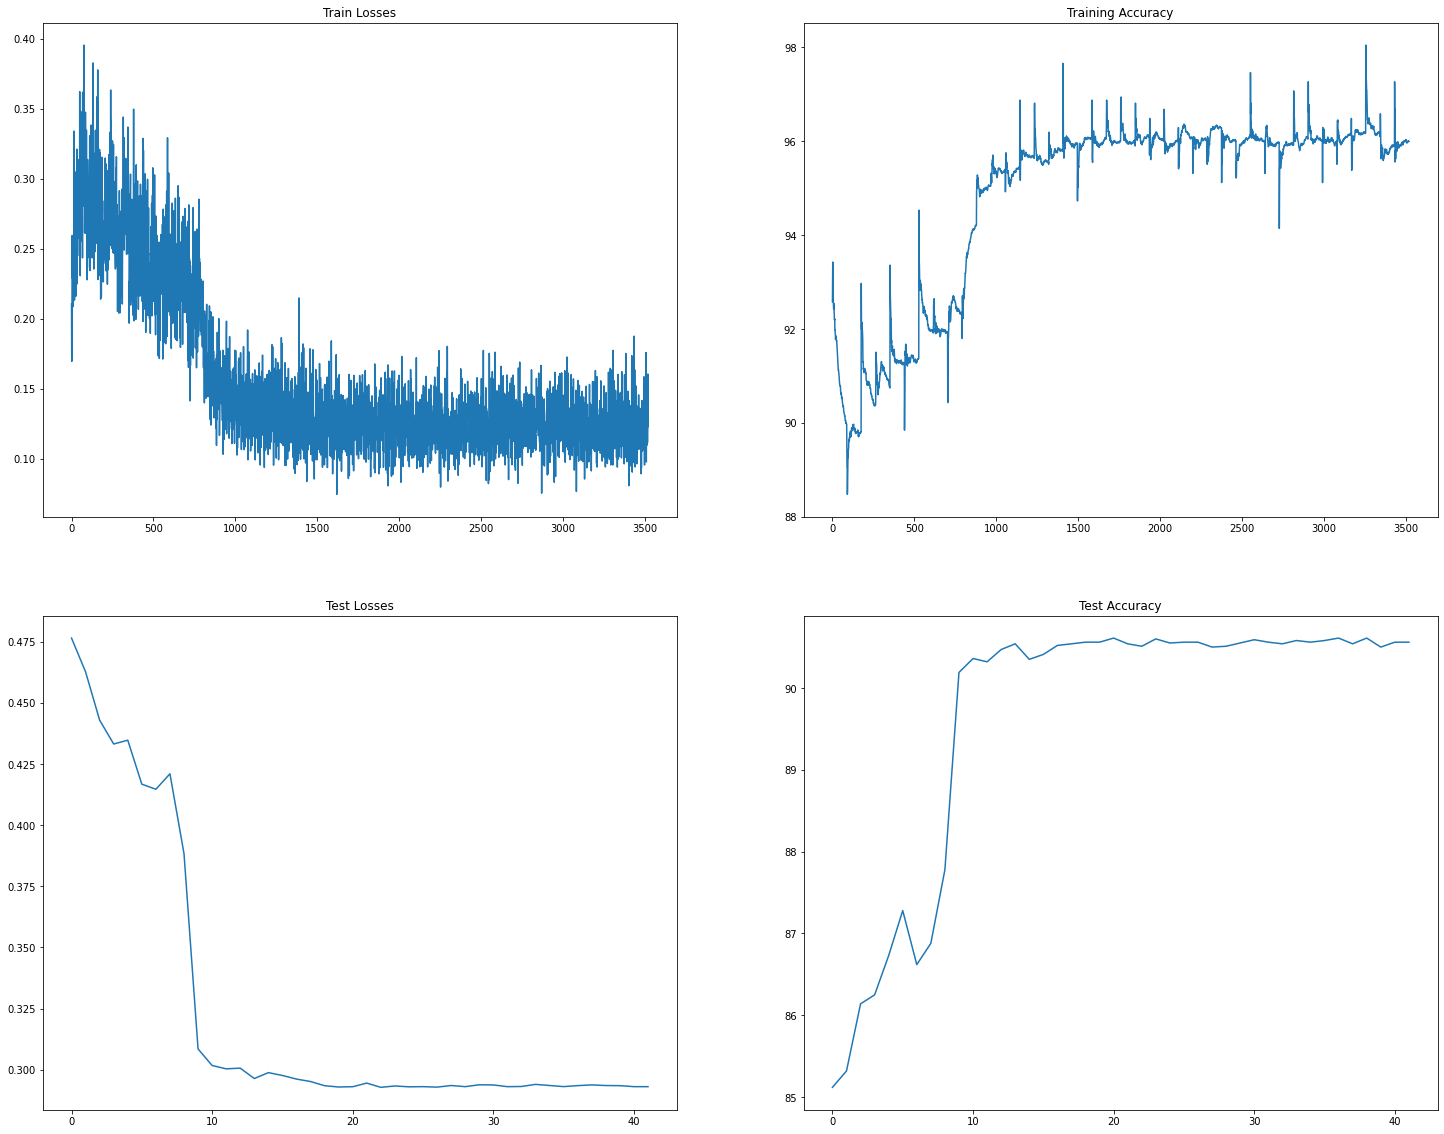

In [26]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)